In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv


In [4]:
#import and download libraries
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
#function to clean and preprocess the text
def clean_text_list(sentences):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'https?\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.strip()
        return text

    cleaned_sentences = []
    for sentence in sentences:
        sentence = clean_text(sentence)
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [
            lemmatizer.lemmatize(token, pos='v') 
            for token in tokens if token.lower() not in stop_words
        ]
        cleaned_sentences.append(lemmatized_tokens)
    
    return cleaned_sentences


In [6]:
#load dataset
df_train = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
sentences = list(df_train['text'])
cleaned_sentences = clean_text_list(sentences)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


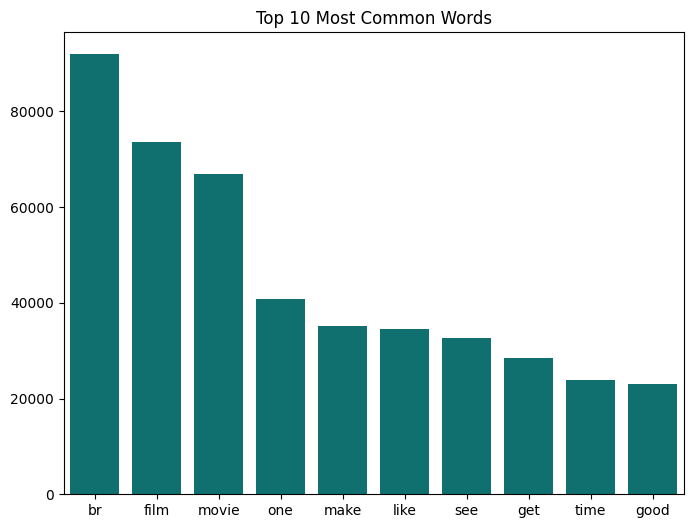

In [7]:
#visualize most common words
from collections import Counter

total_words = [word for sentence in cleaned_sentences for word in sentence]
word_freq = Counter(total_words)

words = [word[0] for word in word_freq.most_common(10)]
counts = [word[1] for word in word_freq.most_common(10)]

plt.figure(figsize=(8, 6))
sns.barplot(x=words, y=counts, color='teal')
plt.title('Top 10 Most Common Words')
plt.show()

In [8]:
#convert text to integer values and apply padding
vocab_size = 10000
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_sentences)

sequences = tokenizer.texts_to_sequences(cleaned_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [9]:
#access labels
labels = np.array(df_train['label'])

In [12]:
#3 layer lstm training
three_layer_lstm = keras.Sequential()
three_layer_lstm.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
three_layer_lstm.add(keras.layers.LSTM(128, return_sequences=True))
three_layer_lstm.add(keras.layers.Dropout(0.5))
three_layer_lstm.add(keras.layers.LSTM(64, return_sequences=True))
three_layer_lstm.add(keras.layers.Dropout(0.5))
three_layer_lstm.add(keras.layers.LSTM(32, return_sequences=False))
three_layer_lstm.add(keras.layers.Dropout(0.5))
three_layer_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

three_layer_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
three_layer_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_3_lstm = three_layer_lstm.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5020 - loss: 0.6934 - val_accuracy: 0.5017 - val_loss: 0.6931
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5070 - loss: 0.6926 - val_accuracy: 0.5339 - val_loss: 0.6858
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6514 - loss: 0.6436 - val_accuracy: 0.5086 - val_loss: 0.6918
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5211 - loss: 0.6870 - val_accuracy: 0.5928 - val_loss: 0.6833
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5682 - loss: 0.6673 - val_accuracy: 0.6560 - val_loss: 0.6103
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6710 - loss: 0.5950 - val_accuracy: 0.7244 - val_loss: 0.5823
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7365 - loss: 0.5739 - val_accuracy: 0.7495 - val_loss: 0.5658
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7479 - loss: 0.5681 - 

In [14]:
#3 layer gru training
three_layer_gru = keras.Sequential()

three_layer_gru.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
three_layer_gru.add(keras.layers.GRU(128, return_sequences=True)) 
three_layer_gru.add(keras.layers.Dropout(0.5))
three_layer_gru.add(keras.layers.GRU(64, return_sequences=True))   
three_layer_gru.add(keras.layers.Dropout(0.5))
three_layer_gru.add(keras.layers.GRU(32, return_sequences=False)) 
three_layer_gru.add(keras.layers.Dropout(0.5))
three_layer_gru.add(keras.layers.Dense(1, activation='sigmoid'))   

three_layer_gru.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
three_layer_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_3_gru = three_layer_gru.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5050 - loss: 0.6932 - val_accuracy: 0.5054 - val_loss: 0.6936
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5142 - loss: 0.6926 - val_accuracy: 0.5031 - val_loss: 0.6923
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5104 - loss: 0.6905 - val_accuracy: 0.5224 - val_loss: 0.6849
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5435 - loss: 0.6700 - val_accuracy: 0.6607 - val_loss: 0.6393
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5661 - loss: 0.6526 - val_accuracy: 0.7389 - val_loss: 0.6746
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7630 - loss: 0.6006 - val_accuracy: 0.7581 - val_loss: 0.5565
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7484 - loss: 0.5715 - val_accuracy: 0.5978 - val_loss: 0.6354
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6424 - loss: 0.6129 - 

In [16]:
#4 layer bi-directional lstm training
bidirectional_lstm = keras.Sequential()

bidirectional_lstm.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
bidirectional_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))  
bidirectional_lstm.add(keras.layers.Dropout(0.5))
bidirectional_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))  
bidirectional_lstm.add(keras.layers.Dropout(0.5))
bidirectional_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)))   
bidirectional_lstm.add(keras.layers.Dropout(0.5))
bidirectional_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=False)))    
bidirectional_lstm.add(keras.layers.Dropout(0.5))
bidirectional_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  

bidirectional_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_4_bilstm = bidirectional_lstm.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.6122 - loss: 0.6280 - val_accuracy: 0.8583 - val_loss: 0.3575
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.8909 - loss: 0.3159 - val_accuracy: 0.8773 - val_loss: 0.3086
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9233 - loss: 0.2383 - val_accuracy: 0.8779 - val_loss: 0.2989
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9378 - loss: 0.2020 - val_accuracy: 0.8839 - val_loss: 0.3177
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9516 - loss: 0.1691 - val_accuracy: 0.8825 - val_loss: 0.3381
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9641 - loss: 0.1404 - val_accuracy: 0.8796 - val_loss: 0.3662
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9692 - loss: 0.1241 - val_accuracy: 0.8774 - val_loss: 0.4183
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9739 - loss: 0.1104 - 

In [18]:
#testing
df_test = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')
test_sentences = list(df_test['text'])
cleaned_test_sentences = clean_text_list(test_sentences)

In [19]:
test_sequences = tokenizer.texts_to_sequences(cleaned_test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [20]:
predictions_lstm = three_layer_lstm.predict(padded_test_sequences)
predicted_labels_lstm = (predictions_lstm > 0.5).astype(int) 

predictions_gru = three_layer_gru.predict(padded_test_sequences)
predicted_labels_gru = (predictions_gru > 0.5).astype(int)  

predictions_bidirectional = bidirectional_lstm.predict(padded_test_sequences)
predicted_labels_bidirectional = (predictions_bidirectional > 0.5).astype(int)  

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


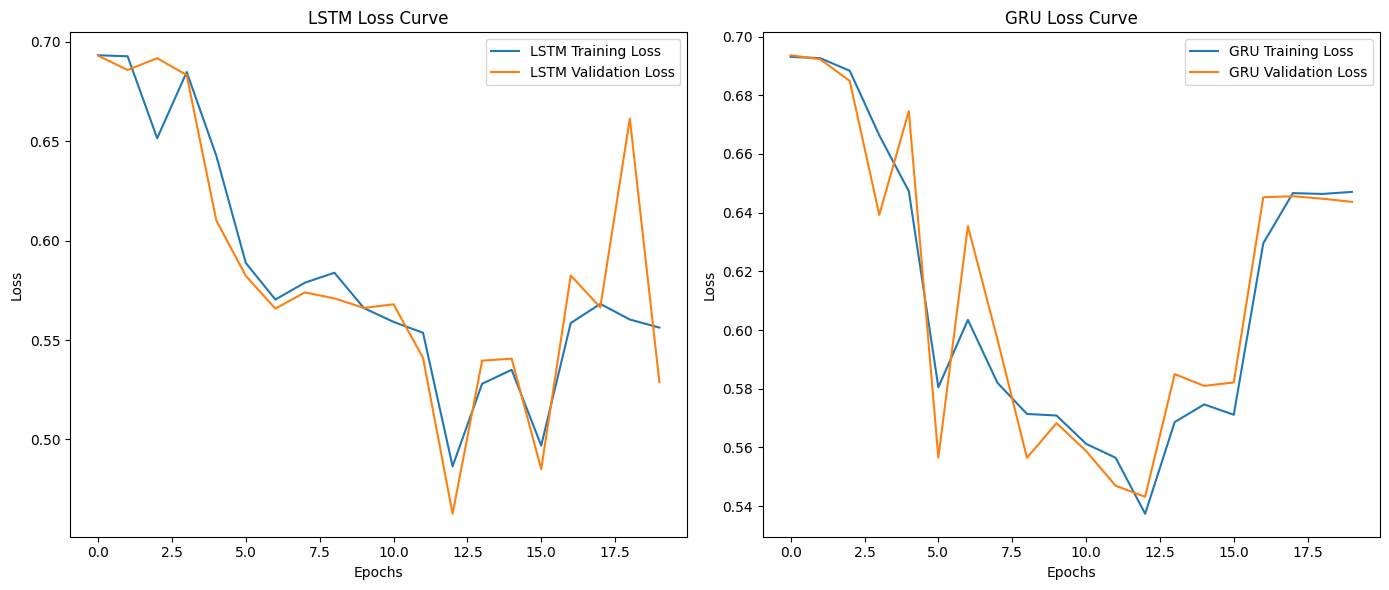

In [21]:
#visualizing loss and accuracy of the 3 models
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_3_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_3_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3_gru.history['loss'], label='GRU Training Loss')
plt.plot(history_3_gru.history['val_loss'], label='GRU Validation Loss')
plt.title('GRU Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

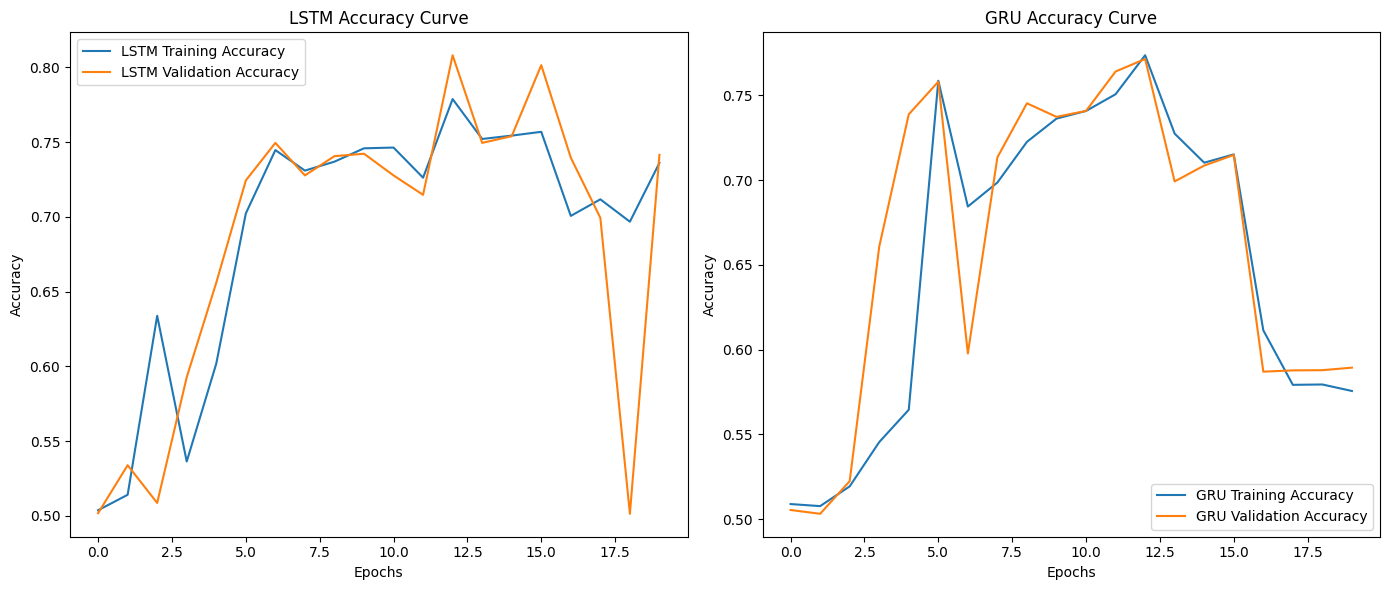

In [22]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_3_lstm.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(history_3_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3_gru.history['accuracy'], label='GRU Training Accuracy')
plt.plot(history_3_gru.history['val_accuracy'], label='GRU Validation Accuracy')
plt.title('GRU Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


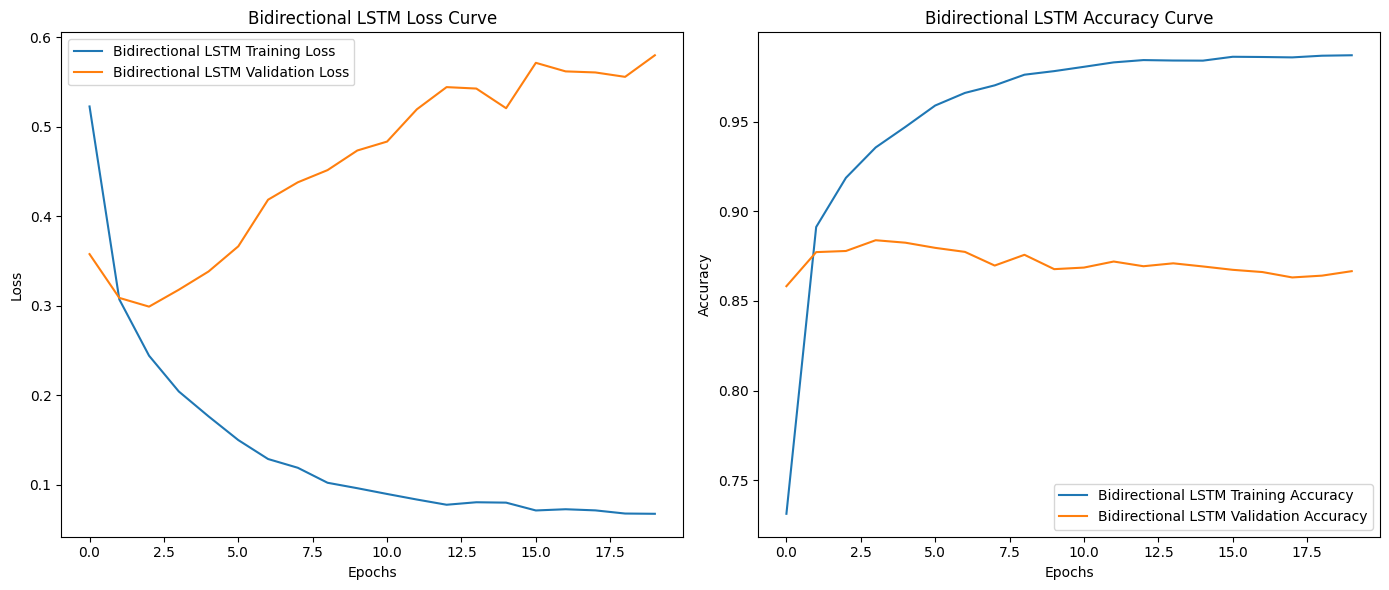

In [23]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_4_bilstm.history['loss'], label='Bidirectional LSTM Training Loss')
plt.plot(history_4_bilstm.history['val_loss'], label='Bidirectional LSTM Validation Loss')
plt.title('Bidirectional LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_4_bilstm.history['accuracy'], label='Bidirectional LSTM Training Accuracy')
plt.plot(history_4_bilstm.history['val_accuracy'], label='Bidirectional LSTM Validation Accuracy')
plt.title('Bidirectional LSTM Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
from sklearn.metrics import accuracy_score

test_labels = np.array(df_test['label'])  


accuracy_lstm = accuracy_score(test_labels, predicted_labels_lstm)
print(f'LSTM Test Accuracy: {accuracy_lstm:.4f}')

accuracy_gru = accuracy_score(test_labels, predicted_labels_gru)
print(f'GRU Test Accuracy: {accuracy_gru:.4f}')

accuracy_bidirectional = accuracy_score(test_labels, predicted_labels_bidirectional)
print(f'Bidirectional LSTM Test Accuracy: {accuracy_bidirectional:.4f}')


LSTM Test Accuracy: 0.7430
GRU Test Accuracy: 0.5880
Bidirectional LSTM Test Accuracy: 0.8572


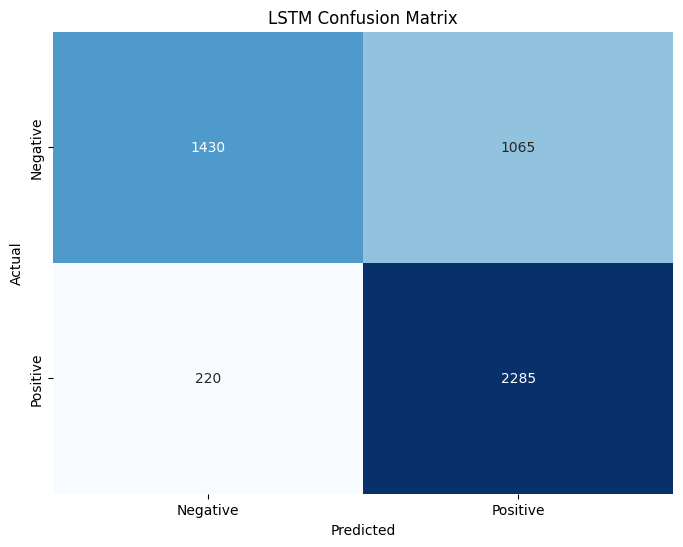

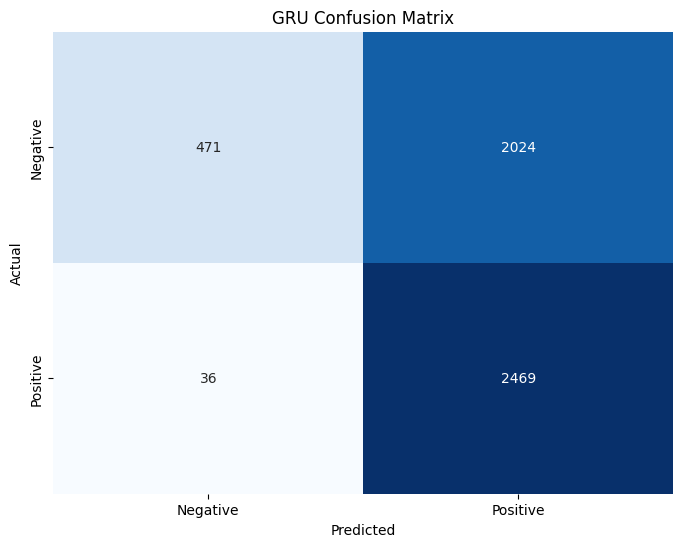

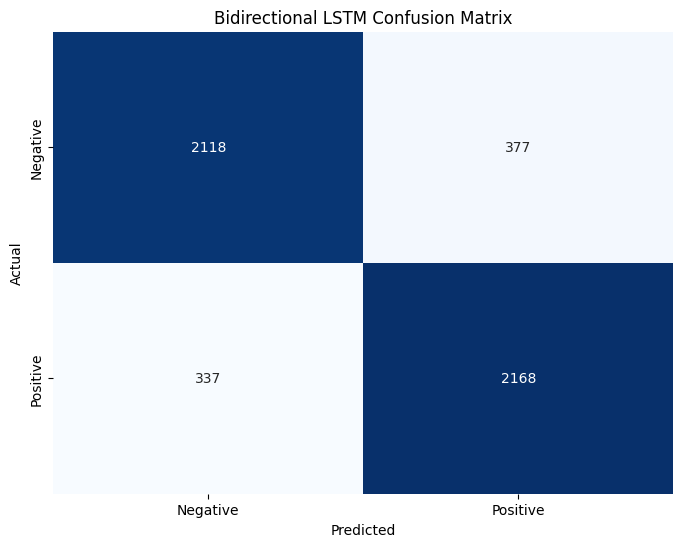

In [27]:
#plotting confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_labels, predicted_labels_lstm, title='LSTM Confusion Matrix')

plot_confusion_matrix(test_labels, predicted_labels_gru, title='GRU Confusion Matrix')

plot_confusion_matrix(test_labels, predicted_labels_bidirectional, title='Bidirectional LSTM Confusion Matrix')
